## Emulator validation

We need some figure to verify the accuracy of emulator predictions through comparison with the truth. Simeon's paper had a cross-validation plot, but this stacks all $z$ and $k$ bins into one histogram. We know that our emulator performance has some redshfit and k dependence, and so it is important this is shown in whatever validation figure we include.

The leave-one-out test I conducted is similar to having a cross-validation at each $k$ and $z$. Although it might require some discussion, lets try and include this figure.

So the way this works is for each simulation we have in the suite, it uses every other simulation to predict a P1D for every snapshot in that test simulation. We store the ratio of the prediction/truth, and the fractional theoretical uncertainty at each k and z.

We can then plot the mean and variance of the prediction/truth (what I would consider to be the true error) and of the fractional theoretical uncertainty as a function of $k$ and $z$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# our own LaCE modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace.cosmo import camb_cosmo

# this is only to have relative errobars from eBOSS
from lace_manager.data import data_Chabanier2019

In [2]:
# make pretty plots
font = {'size'   : 22}
matplotlib.rc('font', **font)
plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [3]:
# specify the P1D archive
basedir="/lace/emulator/sim_suites/Australia20/"
Nsim=30

# specify the range of wavenumbers and redshifts to use (we could vary this)
kmax_Mpc=3 # 8
zmax=4 # 4.5

In [4]:
# specify emulator settings 
emu_type="k_bin" # "polyfit"
drop_tau_rescalings=True # False

In [5]:
# load one of the simulations (#0) to figure out redshift range and wavenumbers
sim=p1d_archive.archiveP1D(basedir=basedir,z_max=zmax,pick_sim_number=0,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)
# get redshifts in simulation
sim_zs=[data['z'] for data in sim.data]
Nz=len(sim_zs)
print('will use {} redshifts / snapshots'.format(Nz))
# get wavenumbers in 1/Mpc units (same for all snapshots in all sims)
sim_k_Mpc=sim.data[0]['k_Mpc']
# use only 0 < k < kmax_Mpc
k_mask=(sim_k_Mpc<kmax_Mpc) & (sim_k_Mpc>0)
sim_k_Mpc=sim_k_Mpc[k_mask]
Nk=len(sim_k_Mpc)
print('will use {} wavenumbers'.format(Nk))

will use 9 redshifts / snapshots
will use 32 wavenumbers


In [6]:
# Set up cosmology to get eBOSS k_max at each z where we have data
cosmo_fid=camb_cosmo.get_cosmology()

In [7]:
# read eBOSS P1D to plot relative error bars
chab=data_Chabanier2019.P1D_Chabanier2019()

In [8]:
def leave_one_out_rbf():
    """ This will loop over each simulation in the suite. It will load all other simulations
    as training data, and use the default hyperparameters to make an emulator prediction.
    It then calculates the mean and variance of the prediction/truth ratio, and the mean
    and the variance of the fractional error as a function of k and z"""
    
    ## Data arrays
    fractional_error=np.empty((Nsim,Nz,Nk))
    theory_error=np.empty((Nsim,Nz,Nk))

    for simnum in range(0,Nsim):
        
        # archive containing only a given simulation
        truth=p1d_archive.archiveP1D(basedir=basedir,z_max=zmax,pick_sim_number=simnum,
                                drop_tau_rescalings=True,drop_temp_rescalings=True)
        
        # archive containing all other simulations
        training=p1d_archive.archiveP1D(basedir=basedir,z_max=zmax,drop_sim_number=simnum,
                                drop_tau_rescalings=drop_tau_rescalings,drop_temp_rescalings=True)
                            
        # create emulator from training set
        emu_test=gp_emulator.GPEmulator(basedir,z_max=zmax,kmax_Mpc=kmax_Mpc,
                                train=True,asymmetric_kernel=True,rbf_only=True,
                                passarchive=training,emu_type=emu_type,check_hull=False)       
        
        # for each entry (z) in truth/test simulation, compute residuals
        for aa,item in enumerate(truth.data):
            # figure out redshift for this entry
            z=item["z"]
            
            # true p1d (some sims have an extra k bin, so we need to define mask again)
            true_k=item["k_Mpc"]
            k_mask=(true_k<kmax_Mpc) & (true_k>0)
            true_p1d=item["p1d_Mpc"][k_mask]
            assert len(true_p1d)==Nk
            
            # for each entry, figure emulator parameter describing it (labels)
            emu_call={}
            for bb,param in enumerate(emu_test.paramList):
                emu_call[param]=item[param]

            # ask emulator to emulate P1D (and its uncertainty)
            emu_p1d,emu_err=emu_test.emulate_p1d_Mpc(emu_call,sim_k_Mpc,return_covar=True)
            
            # fractional error and uncertainty
            fractional_error[simnum,aa,:]=emu_p1d/true_p1d
            theory_error[simnum,aa,:]=(np.sqrt(np.diag(emu_err)))/emu_p1d
            
    return np.mean(fractional_error,axis=0),np.std(fractional_error,axis=0),np.median(theory_error,axis=0),np.std(theory_error,axis=0)

In [9]:
# population statistics from leave-one-out tests
mean_ratio_rbf,std_ratio_rbf,mean_error_rbf,var_error_rbf=leave_one_out_rbf()

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
GPs optimised in 0.36 seconds
Training GP on 261 points
GPs optimised in 0.28 seconds
Training GP on 261 points
GPs optimised in 0.26 seconds
Training GP on 261 points
GPs optimised in 0.27 seconds
Training GP on 261 points
GPs optimised in 0.32 seconds
Training GP on 261 points
GPs optimised in 0.35 seconds
Training GP on 261 points
GPs optimised in 0.44 seconds
Training GP on 261 points
GPs optimised in 0.29 seconds
Training GP on 261 points
GPs optimised in 0.38 seconds
Training GP on 261 points
GPs optimised in 0.31 seconds
Training GP on 261 points
GPs optimised in 0.37 seconds
Training GP on 261 points
GPs optimised in 0.31 seconds
Training GP on 261 points
GPs optimised in 0.33 seconds
Training GP on 261 points
GPs optimised in 0.34 seconds
Training GP on 261 points
GPs optimised in 0.27 seconds
Training GP on 261 points
GPs optimised in 0.28 seconds
Training GP on 261 points
GPs optimised in 0.32 seconds
Training GP on 261 points
GPs optimised in 0.32 

findfont: Font family ['FreeSerif'] not found. Falling back to DejaVu Sans.


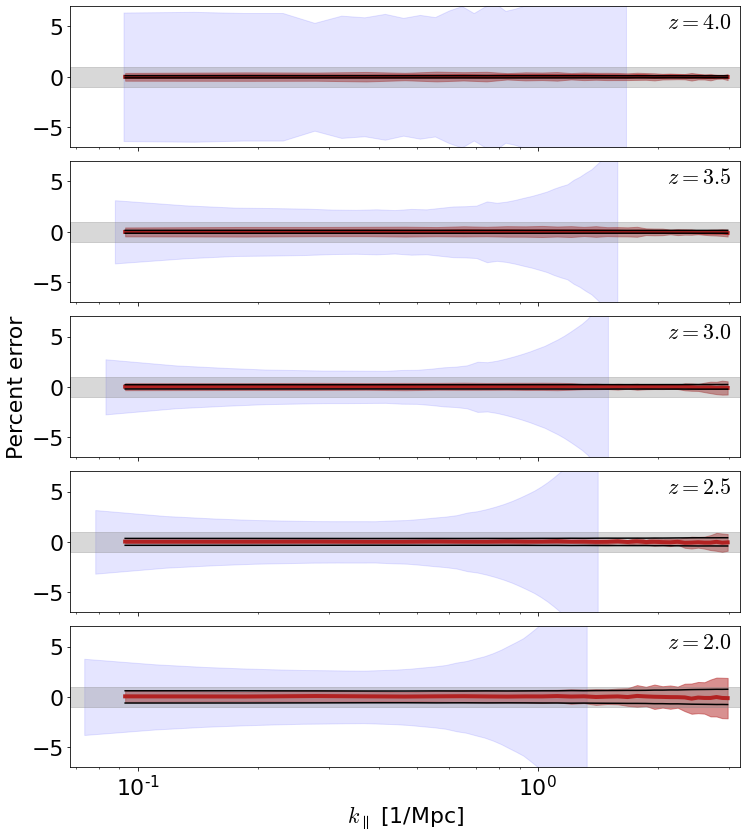

In [10]:
plt.figure(figsize=[12,14])

xmin=0.068
xmax=3.2

for aa in range(0,Nz,2):
    plt.subplot(int((Nz+1)/2),1,int(aa/2)+1)
    col = "firebrick"

    # Chabanier fractional error for comparison (in 1/Mpc)
    sim_z=sim_zs[aa]
    chab_index=np.abs(sim_z - chab.z).argmin()
    chab_pk=chab.get_Pk_iz(chab_index)
    chab_cov=chab.get_cov_iz(chab_index)
    chab_err=np.sqrt(np.diag(chab_cov))
    data_k=chab.k*camb_cosmo.dkms_dMpc(cosmo_fid,sim_z)
    plt.fill_between(data_k,100*chab_err/chab_pk,-100*chab_err/chab_pk,alpha=0.1,color="blue")

    # mean residual
    plt.plot(sim_k_Mpc,100*(mean_ratio_rbf[aa,:]-1),color=col,label="z=%.2f" % sim_z,linewidth=4)

    # +/- mean theoretical uncertainty
    plt.plot(sim_k_Mpc,100*(mean_error_rbf[aa,:]),color="black")
    plt.plot(sim_k_Mpc,-100*mean_error_rbf[aa,:],color="black")
    
    # +/- rms of residuals
    plt.fill_between(sim_k_Mpc,100*((mean_ratio_rbf[aa,:]+std_ratio_rbf[aa,:])-1),
            100*((mean_ratio_rbf[aa,:]-std_ratio_rbf[aa,:])-1),alpha=0.5,color=col)
    
    # 1% gray band
    plt.axhspan(-1,1,color="gray",alpha=0.3)

    # x-y limits
    plt.ylim(-7,7)
    plt.xlim(0.73*sim_k_Mpc[0],1.074*sim_k_Mpc[-1])
    ax = plt.gca()
    ax.set_xscale("log")

    # add redshift label
    ax.text(2.1,4.8,r"$z=%.1f$" % sim_z)

    if aa != Nz-1:
        ax.axes.xaxis.set_ticklabels([])
        #ax.axes.yaxis.set_ticklabels([])
    if aa==int((Nz-1)/2):
        plt.ylabel("Percent error")

plt.subplots_adjust(hspace=0.1)
plt.xlabel(r"$k_\parallel$ [1/Mpc]")
plt.savefig("one_out.pdf", bbox_inches = 'tight',pad_inches = 0)